# FEniCS simulation of Eshelby's circular inclusion problem

The aim of this notebook is to setup a very simple FEniCS simulation. The framework is linear, plane strain elasticity. We model a matrix in a disk around the origin (radius $R_m$) with an inclusion having the shape of another disk around the origin, with a smaller radius ($R_i < R_e$). The matrix and the inclusion have different elastic modulus ($E$: Young modulus; $\nu$: Poisson ratio) but are both isotropic and linearly elastic.

\begin{equation}
\sigma_{ij} = \lambda\varepsilon_{kk}\delta_{ij}+2\mu\varepsilon_{ij},
\end{equation}

where indices $i, j, k$ are restricted to $\{1, 2\}$ and $\lambda$, $\mu$ are the Lamé coefficients :

\begin{equation*}
\mu=\frac{E}{2\bigl(1+\nu\bigr)}
\quad\text{and}\quad
\lambda=\frac{2\mu\nu}{1-2\nu}.
\end{equation*}

The variational formulation of the problem is the following:

Find $u\in \mathcal{C}\equiv\{u: H^1(\Omega), \; u(x_1,x_2)|_{x_1^2+x_2^2=R_e^2}
%\text{border}
=(-x_2,-x_1)\}$ such that 
$\forall v\in \mathcal{C}_0\equiv \mathcal{C}$


\begin{equation}
\int_\Omega \sigma(\varepsilon(u)):\varepsilon(v)\,\mathrm{d}x\,\mathrm{d}y =
\int_{\Omega} b \cdot v\,\mathrm{d} x\,\mathrm{d} y,
\end{equation}

where the body force $b=0$ and $\sigma(\varepsilon)$ is the constitutive equation and $\varepsilon(u)=\mathrm{sym} (\nabla u)$  

![shema](inclusion_shear.png)

you can find help here:

- Mesh generation
   - https://jorgensd.github.io/dolfinx-tutorial/chapter1/membrane_code.html
   - https://jorgensd.github.io/dolfinx-tutorial/chapter2/ns_code2.html#mesh-generation
   - https://docs.fenicsproject.org/dolfinx/main/python/demos/demo_gmsh.html
- Dirichlet bc
    - https://jorgensd.github.io/dolfinx-tutorial/chapter1/fundamentals_code.html#defining-the-boundary-conditions
    - https://jorgensd.github.io/dolfinx-tutorial/chapter2/linearelasticity_code.html#boundary-conditions
    - https://jorgensd.github.io/dolfinx-tutorial/chapter3/component_bc.html
- Visualization in Paraview
    - https://jorgensd.github.io/dolfinx-tutorial/chapter1/membrane_paraview.html
- Interpolating the strain tensor once we have the displacement vector
    - https://jorgensd.github.io/dolfinx-tutorial/chapter2/linearelasticity_code.html#stress-computation
- pyvista
    - https://jorgensd.github.io/dolfinx-tutorial/chapter2/linearelasticity_code.html#visualization
    - https://docs.fenicsproject.org/dolfinx/main/python/demos/demo_pyvista.html
- The Assemble function to perform integrals
    - https://jorgensd.github.io/dolfinx-tutorial/chapter1/fundamentals_code.html#computing-the-error
- Convergence study
    - https://jorgensd.github.io/dolfinx-tutorial/chapter4/convergence.html

In [1]:
import dolfinx # FEM in python
import matplotlib.pyplot as plt
import ufl # variational formulations
import numpy as np
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
import gmsh # Mesh generation
import dolfinx.mesh as mesh #from fracture 

In [2]:
import pyvista # visualisation in python notebook

In [3]:
# ONLY EXCUTE ONCE if needed for pyvista
# !pip install ipyvtklink==0.2.3 

In [4]:
import extract # this to be able to have the value of a solution at point (x,y)
# use it this way : extract.solution(my_domain, u_solution, x=0.5, y=0.01)

# Parameters of the simulation

In [5]:
# Geometry
R_i = 1.0 # Radius of the inclusion
R_e = 6.9  # Radius of the matrix (whole domain)
aspect_ratio = 1.0 # start with a circle, otherwise ellipse

In [6]:
# Material
E_m = 1.0 # Young's modulus in matrix
nu_m = 0.35 # Poisson's ratio in matrix
E_i = 11.0 # Young's modulus of inclusion
nu_i = 0.3 # Poisson's ratio in inclusion

## Create the mesh with gmsh

In [7]:
mesh_size = R_i/3
mesh_order = 1 

mesh_comm = MPI.COMM_WORLD
model_rank = 0
gmsh.initialize()
facet_names = {"inner_boundary": 1, "outer_boundary": 2}
cell_names = {"inclusion": 1, "matrix": 2}
model = gmsh.model()
model.add("Disk")
model.setCurrent("Disk")
gdim = 2 # geometric dimension of the mesh
inner_disk = gmsh.model.occ.addDisk(0, 0, 0, R_i, aspect_ratio * R_i)
outer_disk = gmsh.model.occ.addDisk(0, 0, 0, R_e, R_e)
whole_domain = gmsh.model.occ.fragment([(gdim, outer_disk)], [(gdim, inner_disk)])
gmsh.model.occ.synchronize()

# Add physical tag for bulk
inner_domain = whole_domain[0][0]
outer_domain = whole_domain[0][1]
model.addPhysicalGroup(gdim, [inner_domain[1]], tag=cell_names["inclusion"])
model.setPhysicalName(gdim, inner_domain[1], "Inclusion")
model.addPhysicalGroup(gdim, [outer_domain[1]], tag=cell_names["matrix"])
model.setPhysicalName(gdim, outer_domain[1], "Matrix")

# Add physical tag for boundaries
lines = gmsh.model.getEntities(dim=1)
inner_boundary = lines[1][1]
outer_boundary = lines[0][1]
gmsh.model.addPhysicalGroup(1, [inner_boundary], facet_names["inner_boundary"])
gmsh.model.addPhysicalGroup(1, [outer_boundary], facet_names["outer_boundary"])
gmsh.option.setNumber("Mesh.CharacteristicLengthMin",mesh_size)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",mesh_size)
model.mesh.generate(gdim)
gmsh.option.setNumber("General.Terminal", 1)
model.mesh.setOrder(mesh_order)
gmsh.option.setNumber("General.Terminal", 0)

# Import the mesh in dolfinx
from dolfinx.io import gmshio
domain, cell_tags, facet_tags = gmshio.model_to_mesh(model, mesh_comm, model_rank, gdim=gdim)
domain.name = "composite"
cell_tags.name = f"{domain.name}_cells"
facet_tags.name = f"{domain.name}_facets"
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 50%] Meshing curve 2 (Ellipse)
Info    : Done meshing 1D (Wall 0.0396262s, CPU 0s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.192742s, CPU 0.087241s)
Info    : 1689 nodes 3397 elements


In [8]:
print(domain)

In [9]:
print(inner_domain)

(2, 1)


In [10]:
print(inner_disk)

1


In [11]:
print(whole_domain)

([(2, 1), (2, 2)], [[(2, 2), (2, 1)], [(2, 1)]])


In [12]:
print(cell_tags)

In [13]:
print(facet_tags)

In [14]:
cell_names["matrix"]

2

In [15]:
facet_names["outer_boundary"]

2

In [16]:
cell_names["inclusion"]

1

In [17]:
facet_names["inner_boundary"]

1

# `Questions start here`

# 0) Export the mesh as a xdmf file and open it in Paraview

In [18]:
# Save the mesh in XDMF format
with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "output/mesh.xdmf", "w") as file:
    file.write_mesh(domain)
    domain.topology.create_connectivity(1, 2)
    file.write_meshtags(cell_tags, geometry_xpath=f"/Xdmf/Domain/Grid[@Name='{domain.name}']/Geometry")
    file.write_meshtags(facet_tags, geometry_xpath=f"/Xdmf/Domain/Grid[@Name='{domain.name}']/Geometry")

# 1) Plot the mesh with a color code to locate the inclusion and the matrix

In [19]:
from dolfinx.plot import create_vtk_mesh
pyvista.set_jupyter_backend("none") # non-interactiv, but sometimes better

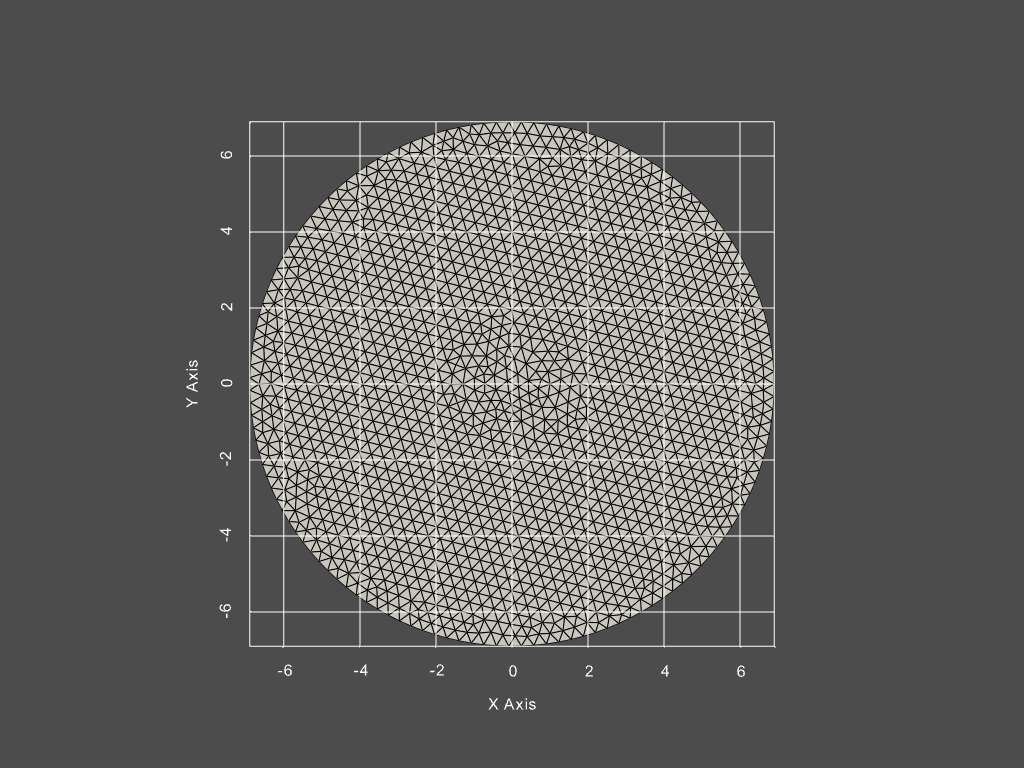

In [20]:
grid = pyvista.UnstructuredGrid(*create_vtk_mesh(domain))
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.show_bounds(grid='front', location='outer', all_edges=True)
plotter.view_xy()
plotter.show()

# 2) Define integral over the two domains domains

In [21]:
ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tags) # on précise aussi le numéro de sous-domaine avec facet_tags
dx = ufl.Measure("dx", domain=domain, subdomain_data=cell_tags)   # idem

one = dolfinx.fem.Constant(domain,ScalarType(1.))
print(one)
print(ds)
print(dx)
print(dx(1))

c_0
ds(subdomain_id=everywhere, domain=<Mesh #0>, subdomain_data=<dolfinx.cpp.mesh.MeshTags_int32 object at 0x7faed19cd530>)
dx(subdomain_id=everywhere, domain=<Mesh #0>, subdomain_data=<dolfinx.cpp.mesh.MeshTags_int32 object at 0x7fae846700f0>)
dx(subdomain_id=1, domain=<Mesh #0>, subdomain_data=<dolfinx.cpp.mesh.MeshTags_int32 object at 0x7fae846700f0>)


In [22]:
# we obtain the values for the aras 
# area_inclusion = dolfinx.fem.assemble_XXXX(XXX one* dx(1))
# area_matrix = dolfinx.fem.assemble_XXXX(XXX * dx(2))
# area_domain = dolfinx.fem.assemble_XXXX(XXX * ufl.dx)

area_inclusion = dolfinx.fem.assemble_scalar(dolfinx.fem.form(one * dx(1)))
area_matrix = dolfinx.fem.assemble_scalar(dolfinx.fem.form(one * dx(2)))
area_domain = dolfinx.fem.assemble_scalar(dolfinx.fem.form(one * ufl.dx))
print(area_inclusion, area_matrix, area_domain)

# compare with analytical values
s_inclusion = np.pi*R_i**2
s_domain = np.pi*R_e**2
s_matrix = s_domain - s_inclusion
print(s_inclusion, s_matrix, s_domain)


3.0846449574444925 146.42924044733664 149.51388540478123
3.141592653589793 146.42963358382028 149.57122623741006


# 3) Define the elastic problem

In [23]:
V = dolfinx.fem.VectorFunctionSpace(domain,("Lagrange", 1),dim=2)

def eps(u):
    return ufl.sym(ufl.grad(u))

I2 = ufl.Identity(2)

# Hooke's law is written as the top of this notebook
def sigma(eps, E, nu):
    mu = E/(2*(1+nu))
    lamb = 2*mu*nu/(1-2*nu)
    return lamb*ufl.tr(eps)*I2 + 2*mu*eps

u = ufl.TrialFunction(V)
u_bar = ufl.TestFunction(V)

bilinear_form_inclusion = ufl.inner(sigma(eps(u), E_i, nu_i), eps(u_bar))*dx(1)
bilinear_form_matrix = ufl.inner(sigma(eps(u), E_m, nu_m), eps(u_bar))*dx(2)
bilinear_form = bilinear_form_inclusion + bilinear_form_matrix

g=0.0 # no weight
body_force = dolfinx.fem.Constant(domain, ScalarType((0,-g)))
linear_form = ( ufl.dot(body_force,u_bar)  ) * ufl.dx

# 4) Boundary condition

In [24]:
# this finds the label of the degree of freedom for the nodes on the boundary facets
outer_facets = facet_tags.find(2)
print("tags:", outer_facets)
outer_boundary_dofs = dolfinx.fem.locate_dofs_topological(V, domain.topology.dim - 1, outer_facets)
print("dofs:",outer_boundary_dofs)

tags: [   1    5   13   16   17   23   33   58   60   67  100  102  106  113
  158  163  213  221  223  285  287  359  361  437  439  520  522  541
  613  615  709  711  810  812  914  916 1023 1025 1029 1065 1067 1153
 1155 1280 1282 1286 1333 1419 1423 1466 1560 1604 1694 1696 1839 1844
 1984 1989 2128 2136 2279 2287 2427 2435 2577 2585 2731 2738 2882 2891
 3026 3034 3171 3179 3314 3322 3453 3462 3531 3593 3602 3726 3735 3857
 3862 3932 3987 3993 4063 4066 4069 4072 4115 4122 4186 4189 4226 4229
 4310 4327 4400 4414 4489 4504 4559 4573 4585 4648 4657 4706 4719 4723
 4767 4784 4823 4832 4840 4868 4877 4882 4897 4898 4904 4907 4913 4918
 4922 4925 4928 4931 4932]
dofs: [   0    2    4    8    9   11   13   17   26   27   30   42   43   45
   48   64   66   84   87   88  110  111  136  137  163  164  192  193
  200  225  226  258  259  293  294  329  330  366  367  369  382  383
  413  414  456  457  459  475  504  506  521  553  568  599  600  648
  650  697  699  746  749  797  800  8

In [25]:
uD = dolfinx.fem.Function(V)
u_on_boundary = lambda x: np.array([-x[1], -x[0]], dtype=ScalarType)
uD.interpolate(u_on_boundary)
print(uD)
bc = dolfinx.fem.dirichletbc(uD, outer_boundary_dofs)
#bc = dolfinx.fem.dirichletbc(uD, outer_boundary_dofs)

f


In [26]:
problem = dolfinx.fem.petsc.LinearProblem(bilinear_form, linear_form, bcs=[bc], 
                                          petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
u_solution = problem.solve()

# 4.5) Plot the solution using pyvista

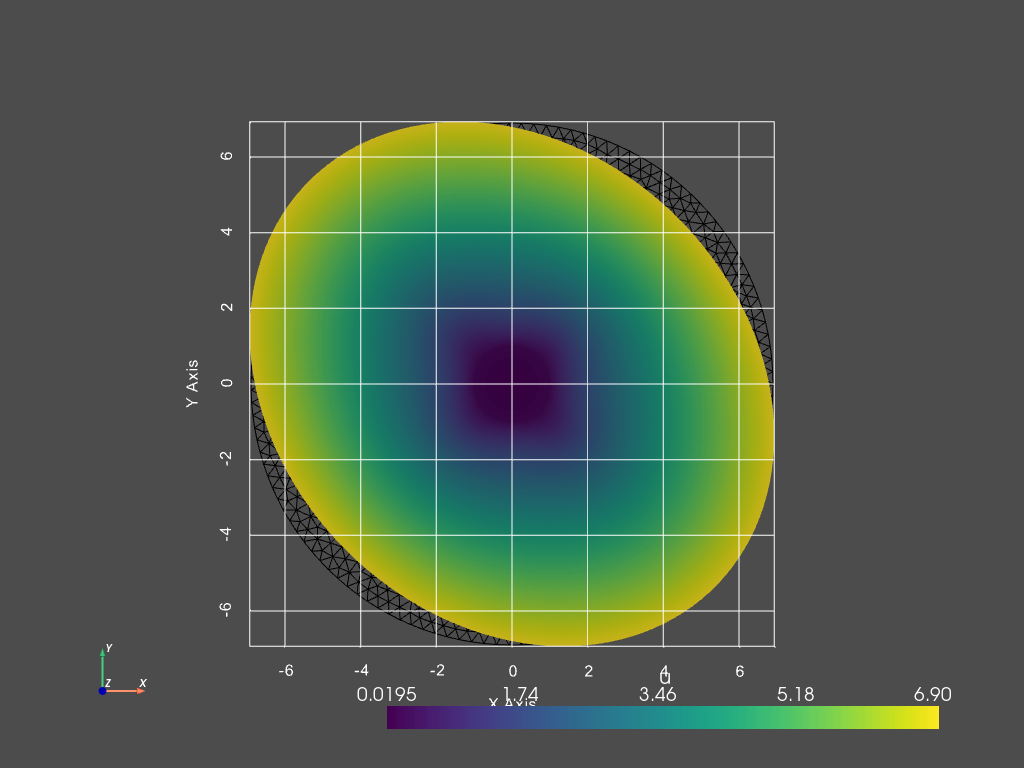

In [27]:
# Create pyvista grid
#pyvista.start_xvfb()
topology, cells, geometry = dolfinx.plot.create_vtk_mesh(u_solution.function_space)
function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)

plotter = pyvista.Plotter() # create plotter

# we add the mesh to the plot #grid is defined above
plotter.add_mesh(function_grid, show_edges=True, style="wireframe", color="k")

# add the deformed shape
values = np.zeros((geometry.shape[0], 3))
values[:, :len(u_solution)] = u_solution.x.array.reshape(geometry.shape[0], len(u_solution))
function_grid["u"] = values
function_grid.set_active_vectors("u")
warped = function_grid.warp_by_vector("u", factor=0.1) # Warp mesh by deformation
plotter.add_mesh(warped) # we add the deformed shape to the plot

# we display the plot with axes and grid
plotter.show_axes()
plotter.view_xy()
plotter.show_bounds(grid='front', location='outer', all_edges=True)
plotter.show()

# 5) Export xdmf file and open it in Paraview

In [28]:
# To have a name in Paraview
u_solution.name = "displacement_vector"

In [29]:
# We export the mesh+solution to see it on Paraview
#with io.XDMFFile(MPI.COMM_WORLD, "output/elasticity-demo.xdmf", "w") as file:
#    file.write_mesh(uh.function_space.mesh)
#    file.write_function(uh)

with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "inclusion-demo.xdmf", "w") as file:
    file.write_mesh(domain)
    file.write_function(u_solution)

# 6) Compute the L2-norm of the solution

$ L^2_\text{norm} = \sqrt{\int_\Omega u^2 dx}$

In [30]:
# L2-norm of the solution
np.sqrt( dolfinx.fem.assemble_scalar(dolfinx.fem.form( ufl.dot(u_solution,u_solution)* ufl.dx)) )

59.01888789899557

In [31]:
extract.solution(domain, u_solution, 0.2, 0.2)

array([-0.02746094, -0.02758251])

## 6.1) In the circular case, here is the analytical solution

In [32]:
from eshelby import EshelbyDisk
solution = EshelbyDisk(V,R_e/R_i, E_i/E_m, nu_i, nu_m)
u_ref_func = solution.to_function(R_i)

In [89]:
np.sqrt( dolfinx.fem.assemble_scalar(dolfinx.fem.form( ufl.dot(u_ref_func,u_ref_func)* ufl.dx)) )

59.03159668097725

In [33]:
# analytical solution
extract.solution(domain, u_ref_func, 0.2, 0.2)

array([-0.02807422, -0.02807395])

In [34]:
# FEM solution
extract.solution(domain, u_solution, 0.2, 0.2)

array([-0.02746094, -0.02758251])

In [35]:
# Are they equal? Why?

# 7) Compute the strain tensor of the solution

In [36]:
# We compute the strain tensor of the solution
eps_solution = eps(u_solution)

## Evaluating $ \epsilon_{ij} $

In [37]:
V_eps = dolfinx.fem.FunctionSpace(domain,("DG", 0)) # 0 - constant ; DG - discontinu Galerkin ; CG - continu Galerkin

In [38]:
eps_xx_expr = dolfinx.fem.Expression(eps_solution[0,0], V_eps.element.interpolation_points()) # eps_solution[0,0] - argument [0,0] - definit la direction xx 
eps_xx = dolfinx.fem.Function(V_eps)
eps_xx.interpolate(eps_xx_expr)

In [39]:
# This should send back the strain at point (0.1,0.2)
extract.solution(domain, eps_xx, 0.1, 0.2)

array([-0.00079795])

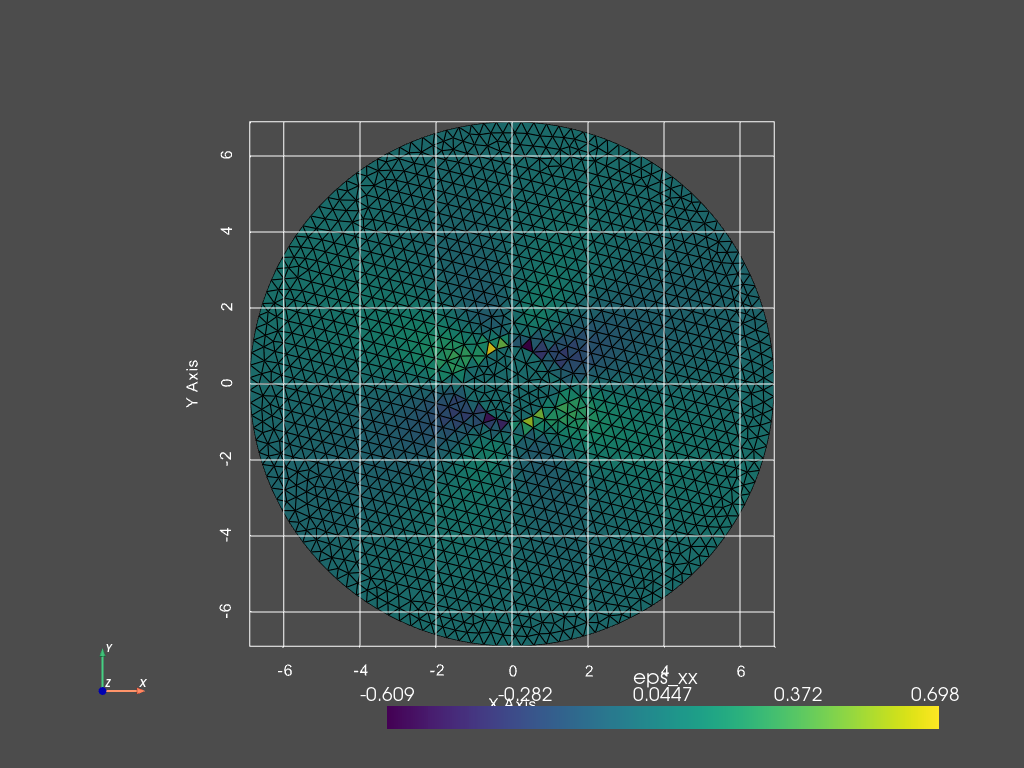

In [40]:
# Plot using pyvista or Paraview

# Create pyvista grid
topology, cells, geometry = dolfinx.plot.create_vtk_mesh(u_solution.function_space)
function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)

plotter = pyvista.Plotter() # create plotter

# Add eps_xx(x,y)
function_grid["eps_xx"] = eps_xx.x.array.real # why real ? 
plotter.add_mesh(function_grid, show_edges=True)

# we display the plot with axes and grid
plotter.show_axes()
plotter.view_xy()
plotter.show_bounds(grid='front', location='outer', all_edges=True)
plotter.show()

# 8) Do the same for $ \epsilon_{xy} $ and $ \epsilon_{yy} $ and 

In [41]:
eps_xy_expr = dolfinx.fem.Expression(eps_solution[0,1], V_eps.element.interpolation_points())
eps_xy = dolfinx.fem.Function(V_eps)
eps_xy.interpolate(eps_xy_expr)

In [42]:
extract.solution(domain, eps_xy, 0.5, 0.3)

array([-0.14746777])

In [43]:
extract.solution(domain, eps_xy, 0.1, 0.2)

array([-0.13630597])

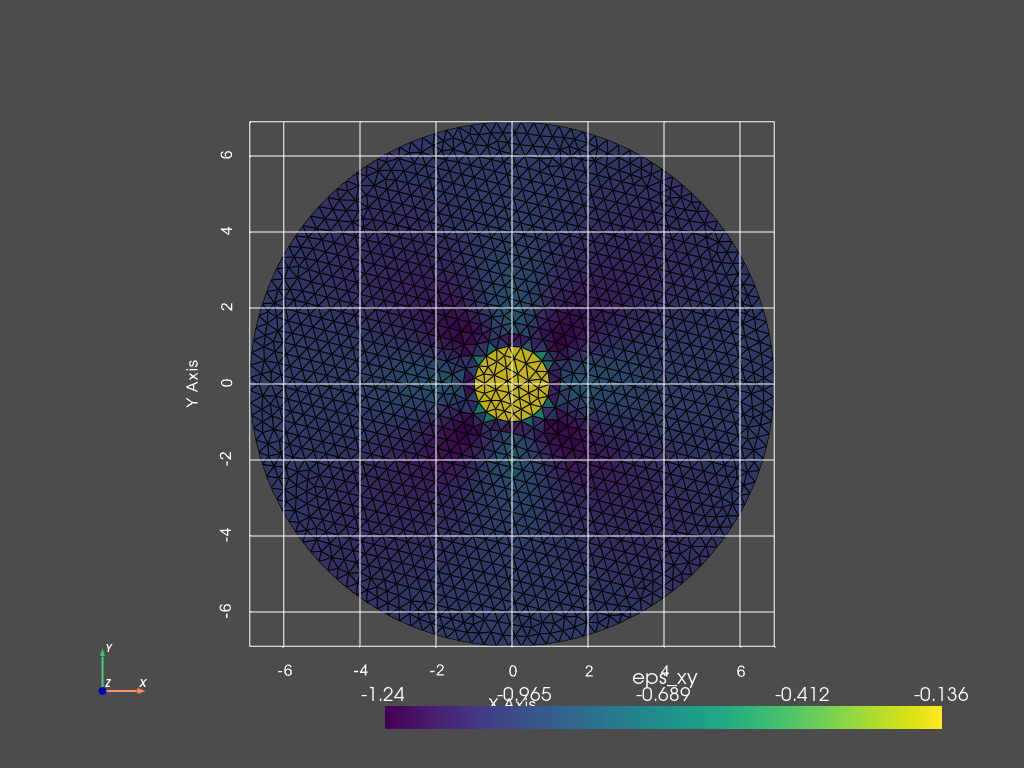

In [44]:
# Plot using pyvista or Paraview

# Create pyvista grid
topology, cells, geometry = dolfinx.plot.create_vtk_mesh(u_solution.function_space)
function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)

plotter = pyvista.Plotter() # create plotter

# Add eps_xy(x,y)
function_grid["eps_xy"] = eps_xy.x.array.real
plotter.add_mesh(function_grid, show_edges=True)

# we display the plot with axes and grid
plotter.show_axes()
plotter.view_xy()
plotter.show_bounds(grid='front', location='outer', all_edges=True)
plotter.show()

In [45]:
# In the limit of a very large matrix, in the case of a circular inclusion, eps_xy(x,y) should be equal to
mu_m = E_m/(2*(1+nu_m))
mu_i = E_i/(2*(1+nu_i))
q = (3-4*nu_m)/(8*mu_m*(1-nu_m))
b = 1/(1+2*q*(mu_i-mu_m))
print('eps_xy_inclusion = ',-b)
# is it the case?

eps_xy_inclusion =  -0.13487629688747005


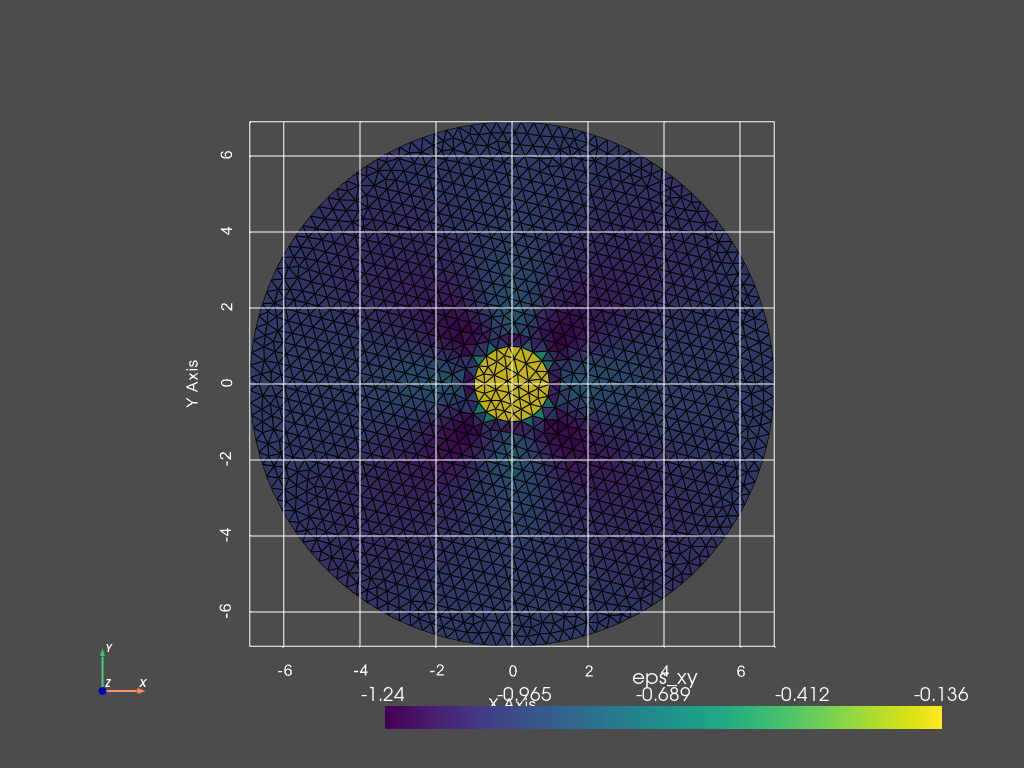

In [46]:
# Plot using pyvista or Paraview

# Create pyvista grid
topology, cells, geometry = dolfinx.plot.create_vtk_mesh(u_solution.function_space)
function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)

plotter = pyvista.Plotter() # create plotter

# add eps_xy(x,y)
function_grid["eps_xy"] = eps_xy.x.array.real
plotter.add_mesh(function_grid, show_edges=True)

# we display the plot with axes and grid
plotter.show_axes()
plotter.view_xy()
plotter.show_bounds(grid='front', location='outer', all_edges=True)
plotter.show()

In [47]:
eps_yy_expr = dolfinx.fem.Expression(eps_solution[1,1], V_eps.element.interpolation_points())
eps_yy = dolfinx.fem.Function(V_eps)
eps_yy.interpolate(eps_yy_expr)

In [48]:
extract.solution(domain, eps_yy, 2.5, 1.1)

array([0.07802971])

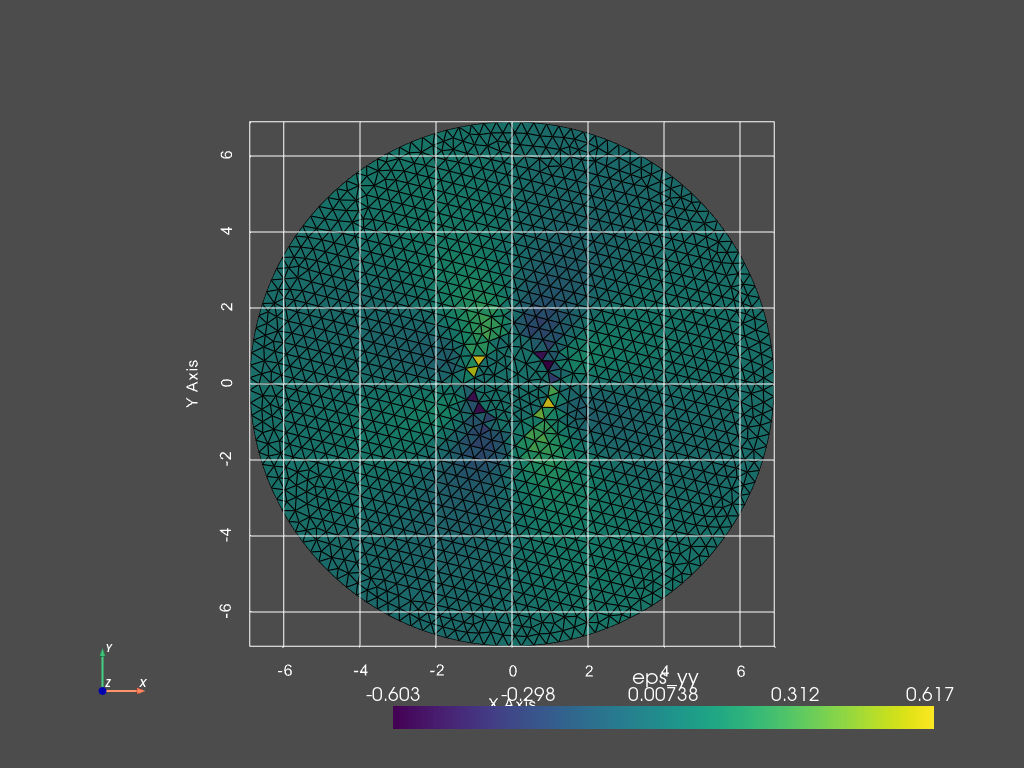

In [49]:
# Plot using pyvista or Paraview

# Create pyvista grid
topology, cells, geometry = dolfinx.plot.create_vtk_mesh(u_solution.function_space)
function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)

plotter = pyvista.Plotter() # create plotter

# add eps_yy(x,y)
function_grid["eps_yy"] = eps_yy.x.array.real
plotter.add_mesh(function_grid, show_edges=True)

# we display the plot with axes and grid
plotter.show_axes()
plotter.view_xy()
plotter.show_bounds(grid='front', location='outer', all_edges=True)
plotter.show()

# 9) Compute mean values over entire domain

\begin{equation}
<\varepsilon_{ij}> = \frac{\int_\Omega \varepsilon_{ij} \,\mathrm{d}x}{ \int_\Omega dx }
\end{equation}

In [50]:
dolfinx.fem.assemble_scalar(dolfinx.fem.form( eps_xx * ufl.dx))  / area_domain

9.924423335307226e-18

In [51]:
dolfinx.fem.assemble_scalar(dolfinx.fem.form( eps_yy * ufl.dx))  / area_domain

2.264648113120303e-18

In [52]:
dolfinx.fem.assemble_scalar(dolfinx.fem.form( eps_xy * ufl.dx))  / area_domain

-0.9999999999999984

# 9.1) Compute mean values over inclusion

In [53]:
mean_eps_xx = dolfinx.fem.assemble_scalar(dolfinx.fem.form( eps_xx * dx(1)))  / area_inclusion

In [54]:
mean_eps_xy = dolfinx.fem.assemble_scalar(dolfinx.fem.form( eps_xy * dx(1)))  / area_inclusion

## How does this mean value change when the ratio $E_{incl}/E_{mat}$ is changing ?

In [55]:
mean_eps_yy = dolfinx.fem.assemble_scalar(dolfinx.fem.form( eps_yy * dx(1)))  / area_inclusion

# 9.2) Compute mean values over matrix

In [56]:
dolfinx.fem.assemble_scalar(dolfinx.fem.form(eps_xx * dx(2))) / area_matrix

-1.818230801894309e-06

In [57]:
dolfinx.fem.assemble_scalar(dolfinx.fem.form(eps_xy * dx(2))) / area_matrix

-1.0179863206118902

In [58]:
dolfinx.fem.assemble_scalar(dolfinx.fem.form(eps_yy * dx(2))) / area_matrix

9.688082515564368e-07

# 9.5) Compute the deviation from uniformity inside inclusion

\begin{equation}
deviation = \frac{\int_\Omega Abs(\varepsilon_{ij} - <\varepsilon_{ij}>) \,\mathrm{d}x }{ <\varepsilon_{ij}> }
\end{equation}

### eps_xx

In [59]:
print(mean_eps_xx)

8.631209067946927e-05


In [60]:
deviation_xx = dolfinx.fem.assemble_scalar(dolfinx.fem.form( abs(eps_xx-mean_eps_xx) * dx(1)))  / mean_eps_xx

In [61]:
print(deviation_xx)

108.6629157408832


### eps_xy

In [62]:
print(mean_eps_xy) 

-0.1461826881290583


In [63]:
deviation_xy = dolfinx.fem.assemble_scalar(dolfinx.fem.form( abs(eps_xy-mean_eps_xy) * dx(1))) / mean_eps_xy

In [64]:
print(deviation_xy)

-0.09926071788776185


### eps_yy

In [65]:
print(mean_eps_yy) 

-4.59896871019894e-05


In [66]:
deviation_yy = dolfinx.fem.assemble_scalar(dolfinx.fem.form( abs(eps_yy-mean_eps_yy) * dx(1))) / mean_eps_yy

In [67]:
print(deviation_yy)

-181.37737143001107


# 11) Plot u_y(x,0) using mathplotlib

In [83]:
# we create two lists 
tol = 0.001 # Avoid hitting the outside of the domain
nbr_pts = 1000 # number of plot points
liste_x = np.linspace(-5 + tol, 5 - tol, nbr_pts) # I will plot for x in (0;1)
liste_y = 0 * liste_x # I will plot for y = 0

In [84]:
# Create a list containing the values of uy at these points
for i, x_i in enumerate(liste_x):
    liste_y[i] = extract.solution(domain, u_solution, x_i,0)[1] # [1] - define la direction y 

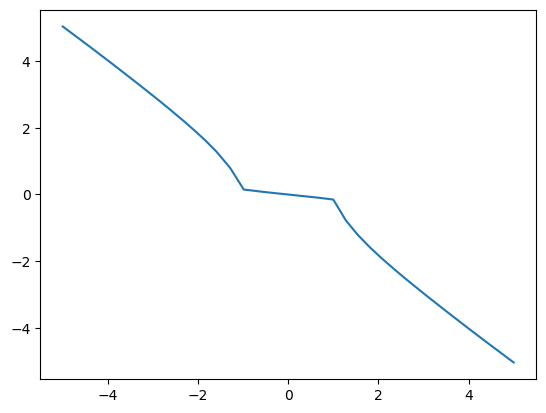

In [85]:
# plot it
plt.plot(liste_x, liste_y)

In [86]:
# Create a list containing the values of uy at these points
for i, x_i in enumerate(liste_x):
    liste_y[i] = extract.solution(domain, u_solution, x_i, 0)[0] # [1] - define la direction y 

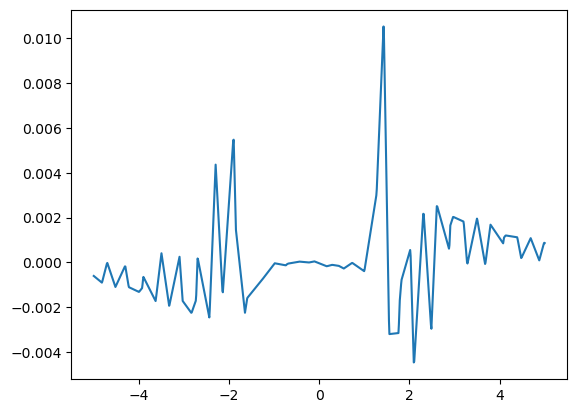

In [87]:
# plot it
plt.plot(liste_x, liste_y)

# 12) Convergence study

## How does the error decrease when the mesh size decreases?

## If the mesh size is divided by 2, is the error divided by 2 also?

## Do the convergence exponents change when the inclusion is elliptical?

# 13) Nondimensionalization

## As usal for statics problems, we can freely choose a length unit, and a force unit.

## Here we choose the length unit to be $R_i$, that is we set $R_i=1$.
## We choose the 'force' unit to be $E_m$, that is we set $E_m=1$.


## 13.1) We have set $R_e=6.9$ in our FEM computations. If, in the real world, the inclusion has radius $R_i=200$ microns, our FEM computations correspond to a matrix of which size? (6.9 microns, 6.9km, or 1.38 mm, or ... ?)

In [76]:
200*6.9/1000

1.38

## 13.2) We have set $E_i = 11$ in our FEM computations. If, in the real world, the matrix has $E_m= 1.2$ GPa, our FEM computations correspond to an inclusion with which Young modulus? (11 GPa, or 13.2 GPa, ... ?)

In [73]:
1.2*11

13.2